In [1]:
import numpy as np
import pandas as pd
from graphviz import Digraph, Graph

In [2]:
data = pd.read_csv('titanic_data.csv')

data1 = data
data1.iloc[:,1] = data1.iloc[:,1].apply(lambda x: 1 if x == 3 else 0)
data1.iloc[:,3] = data1.iloc[:,3].apply(lambda x: 1 if x > 28 else 0)
data1.iloc[:,4] = data1.iloc[:,4].apply(lambda x: 1 if x > 0 else 0)
data1.iloc[:,5] = data1.iloc[:,5].apply(lambda x: 1 if x > 0 else 0)
data1.iloc[:,6] = data1.iloc[:,6].apply(lambda x: 1 if x > 14.45 else 0)

In [24]:
class Node():
    def __init__(self, data, depth = 1, val = None):
        self.left = None
        self.right = None
        self.data = data
        self.y = self.data.Survived
        self.X = self.data.drop(['Survived'],axis = 1)
        
        ## for to_graphviz
        self.val = 'leaf, depth = ' + str(depth) + ' ' + str(val)
        
        self.y_pre = 1 if self.y.sum() >= len(self.y)/2 else 0
        self.label = "y_prediction = " + str(self.y_pre)
        
        ## for prediction
        self.feature = None
        
    def split(self, depth = 1, val = None):
        if self.X.drop_duplicates().shape[0] <= self.X.shape[1]:
            return self
        
        feature, mut_info = self.pick_split()
        ## for prediction
        self.feature = feature

        # for to_graphviz
        self.val = feature + " = 1? depth = " + str(depth) + str(val)
        self.label = feature + " = 1? "

        # split data recursively
        data_left = self.data[self.data[feature] == 0]
        #print(data_left)
        data_right = self.data[self.data[feature] == 1]

        left = Node(data_left, depth + 1, self.val + 'yes')
        right = Node(data_right, depth + 1, self.val + 'no')

        self.left = left
        self.right = right
        
        self.left.split(depth + 1,self.val + 'yes')
        self.right.split(depth + 1, self.val + 'no')
        
        return self
            
        
    def pick_split(self):
        ## follows deck8 8-3
        def mutual(x, y):
            px = np.bincount(x)/x.shape[0]
            Hx = - (px * np.log2(px)).sum()

            py = np.bincount(y)/y.shape[0]
            if len(py) == 1:
                py = np.append(py,0)
            px_y0 = np.bincount(x[y == 0])/x[y == 0].shape[0]
            px_y1 = np.bincount(x[y == 1])/x[y == 1].shape[0]
            
            #print(py)
            #Hy_x = - (px_y0 * np.log2(px_y0)).sum()* py[0] - (px_y1 * np.log2(px_y1)).sum()* py[1]
            H1 = (px_y0 * np.log2(px_y0)).sum()* py[0] if (px_y0 > 0).all() else 0
            H2 = (px_y1 * np.log2(px_y1)).sum()* py[1] if (px_y1 > 0).all() else 0
            Hy_x = - H1 - H2

            return Hx - Hy_x

        mut = self.X.apply(lambda x: mutual(self.y, x))
        val = np.max(mut)
        feature = pd.Series.idxmax(mut)

        return feature, val
        
    def to_graphviz(self, g = None):
        if g == None:
            g = Digraph()
        
        # draw self node
        g.node(self.val, self.label)
        
        for label, child in [('False', self.left), ('True', self.right)]:
            if child != None:
                # draw child node recursively
                child.to_graphviz(g)
                
                # draw edge from self to child
                g.edge(self.val, child.val, label = label)
        return g
    
    def _repr_svg_(self):
        return self.to_graphviz()._repr_svg_()
        
     
    def _predict(self,new):
        if self.left == None and self.right == None:
            return self.y_pre
        
        #print(self.label)
        
        if new[self.feature] == 0:
            return self.left._predict(new)
        else:
            return self.right._predict(new)
        
    def predict(self, new):
        if len(new.shape) == 1: ## single observation
            return self._predict(new)
        else:
            return new.apply(lambda x: self._predict(x), axis = 1)

    

In [25]:
class BST:
    data = pd.read_csv('titanic_data.csv')
    def __init__(self):
        self.data = BST.data
        
        self.data.iloc[:,1] = self.data.iloc[:,1].apply(lambda x: 1 if x == 3 else 0)
        self.data.iloc[:,3] = self.data.iloc[:,3].apply(lambda x: 1 if x > 28 else 0)
        self.data.iloc[:,4] = self.data.iloc[:,4].apply(lambda x: 1 if x > 0 else 0)
        self.data.iloc[:,5] = self.data.iloc[:,5].apply(lambda x: 1 if x > 0 else 0)
        self.data.iloc[:,6] = self.data.iloc[:,6].apply(lambda x: 1 if x > 14.45 else 0)
        
        self.y = self.data.Survived
        self.X = self.data.loc[:,'Pclass':"Fare"]
        
        
    
    
    def create_tree(self, data):
        self.tree = Node(data)
        
        return self.tree.split()
    
    ## prob 4.5
    def cross_val(self, fold = 10):
        indices = np.random.permutation(list(self.data.index))
        testsize = self.data.shape[0]//fold
        acc = []
        for i in range(fold):
            if i == 9:
                test = self.data.loc[indices[i*testsize:]]
                train = self.data.loc[self.data.index.isin(indices[i*testsize:]) == False]
            else:
                test = self.data.loc[indices[i*testsize : (i+1)*testsize]]
                train = self.data.loc[self.data.index.isin(indices[i*testsize : (i+1)*testsize]) == False]
            
            tree = self.create_tree(train)
            acc.append((tree.predict(test) == test.Survived).sum()/len(test.Survived))
            
        return np.array(acc).mean()

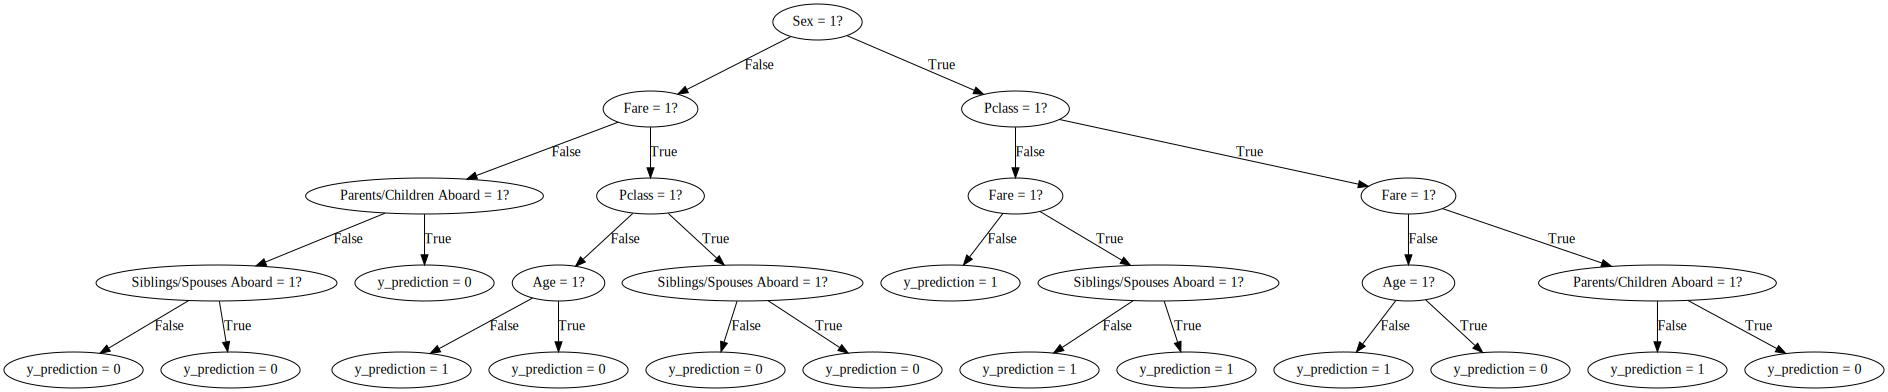

In [26]:
## Please run this cell after running the appendix
Total = BST()
tree = Total.create_tree(Total.data)
tree

In [27]:
type(tree)

__main__.Node

In [28]:
def RandomForest(data, tree_size = 5, sample_subset = 0.8):
    size = round(data.shape[0] * sample_subset)
    BSTs = []
    trees = []
    for i in range(tree_size):
        BSTs.append(BST())
        indices = np.random.permutation(list(data.index))
        trees.append(BSTs[i].create_tree(data.loc[indices[:size]]))
    
    return BSTs,trees

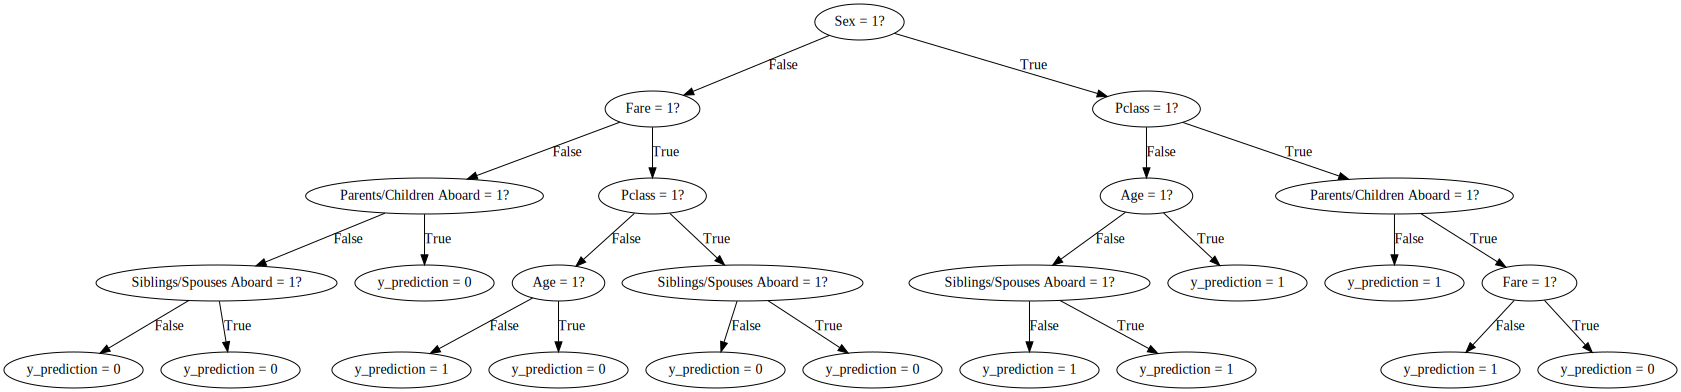

In [29]:
BSTs,RF = RandomForest(data1, tree_size = 5)
RF[0]

In [30]:
def RF_cross_val(data, fold = 10):
        indices = np.random.permutation(list(data.index))
        testsize = data.shape[0]//fold
        acc = []
        for i in range(fold):
            if i == 9:
                test = data.loc[indices[i*testsize:]]
                train = data.loc[data.index.isin(indices[i*testsize:]) == False]
            else:
                test = data.loc[indices[i*testsize : (i+1)*testsize]]
                train = data.loc[data.index.isin(indices[i*testsize : (i+1)*testsize]) == False]
            
            #print(train.shape)
            BSTs, RF = RandomForest(train, tree_size = 5, sample_subset = 0.8)
            
            pre = np.array([itree.predict(test) for itree in RF])
            
            ## summarize 5 trees result
            pre_total = pre.sum(0)
            pre_total[pre_total < 3] = 0
            pre_total[pre_total >= 3] = 1
            
            acc.append((pre_total == test.Survived).sum()/len(test.Survived))
            
        #return np.array(acc).mean()
        return acc

In [31]:
acc = RF_cross_val(data1, fold = 10)

In [32]:
acc

[0.8181818181818182,
 0.7954545454545454,
 0.75,
 0.8295454545454546,
 0.7386363636363636,
 0.8522727272727273,
 0.7613636363636364,
 0.7613636363636364,
 0.7613636363636364,
 0.8105263157894737]

In [ ]:
import sys
import trace

# create a Trace object, telling it what to ignore, and whether to
# do tracing or line-counting or both.
tracer = trace.Trace(
    ignoredirs=[sys.prefix, sys.exec_prefix],
    trace=0,
    count=1)

# run the new command using the given tracer
tracer.run('RF_cross_val(data1, fold = 10)')